# Customer Churn Prediction using ANN

## I. Introduction

Customer churn, the phenomenon where customers stop doing business with a company, is a critical issue for many businesses. Predicting which customers are likely to churn can help companies take proactive measures to retain them, thereby improving customer satisfaction and business profitability. In this notebook, we will build a Customer Churn Prediction model using an Artificial Neural Network (ANN).

We will use a dataset containing various features about customers, such as their credit score, geography, gender, age, tenure, balance, number of products, whether they have a credit card, whether they are active members, and their estimated salary. The target variable is whether the customer has exited (churned) or not.

The steps involved in this notebook include:

1. Importing necessary libraries and setting up the environment.
2. Loading and exploring the dataset.
3. Preprocessing the data to make it suitable for training the ANN.
4. Building and training the ANN model.
5. Evaluating the model's performance.
6. Making predictions on new data.

By the end of this notebook, you will have a robust model that can predict customer churn with a high degree of accuracy.

## II. Import Libraries, Helper Functions & Other Notebook Preferences

### Preferences I

- Supress warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-08-26 13:50:06.656161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preferences II

- Set up visualization aesthetics

In [3]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.size'] = 12

### Helper Functions

Reusable code blocks that perform specific tasks within a data science notebook. They encapsulate common operations or complex logic, making your code more modular, efficient, and easier to maintain.

#### (`viz_distribution`)

Visualize the distribution of any specified column within a given dataset. It uses a histogram with an optional kernel density estimate (KDE) to provide a clear representation of the data distribution, helping to understand the frequency of different values in the specified column.

**Parameters**
1. `data`: DataFrame containing the data.
2. `column_name`: String specifying the column to visualize.
3. `figure_size`: Tuple specifying the dimensions of the plot (default is (8, 6)).
4. `bin_count`: Integer indicating the number of bins for the histogram (default is 30).
5. `discrete`: Boolean indicating whether the data is discrete (default is False).

In [4]:
def viz_distribution(data, column_name, figure_size=(8, 6), bin_count=30, discrete=False):
    plt.figure(figsize=figure_size)
    sns.histplot(data=data, x=column_name, bins=bin_count, kde=True, discrete=discrete)
    plt.title(f'{column_name.capitalize()} Distribution')
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Frequency')
    plt.show()

#### (`viz_categorical_vs_continuous_box_plot`)

Visualizes the relationship between a categorical feature and a continuous feature using a boxplot.

**Parameters**
1. `dataset` (`DataFrame`): The dataset containing the data.
2. `categorical_feature` (`str`): The name of the categorical feature.
3. `continuous_feature` (`str`): The name of the continuous feature.
4. `plot_title` (`str`): The title of the plot.
5. `x_tick_labels` (`list`, `optional`): Labels for the x-axis ticks. Defaults to None.

In [5]:
def viz_categorical_vs_continuous_box_plot(dataset, categorical_feature, continuous_feature, plot_title, x_tick_labels=None):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_feature, y=continuous_feature, data=dataset)
    plt.title(plot_title)
    plt.xlabel(categorical_feature)
    plt.ylabel(continuous_feature)

    if x_tick_labels:
        plt.xticks(ticks=range(len(x_tick_labels)), labels=x_tick_labels)

    plt.show()

#### (`viz_categorical_count_plot`)

Visualizes the count of each category in a categorical feature using a bar plot.

**Parameters**
1. `dataset` (`DataFrame`): The dataset containing the data.
2. `categorical_feature` (`str`): The name of the categorical feature.
3. `plot_title` (`str`): The title of the plot.
4. `x_tick_labels` (`list`, `optional`): Labels for the x-axis ticks. Defaults to None.

In [6]:
def viz_categorical_count_plot(dataset, categorical_feature, plot_title, hue=None, x_tick_labels=None):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=categorical_feature, data=dataset, hue=hue)
    plt.title(plot_title)
    plt.xlabel(categorical_feature)
    plt.ylabel('Count')

    if x_tick_labels:
        plt.xticks(ticks=range(len(x_tick_labels)), labels=x_tick_labels)

    plt.show()

#### (`build_ann_model`)

Builds an Artificial Neural Network (ANN) model using Keras Sequential API.

**Parameters**
1. `shape` (`tuple`): The shape of the input data.

**Returns**
- `model` (`Sequential`): The constructed ANN model.

**Layers and Parameters**
- `Input(shape=shape)`: Defines the shape of the input data. This is necessary to inform the model about the dimensions of the input it will receive.
- `Dense(64, activation='relu')`: Adds a fully connected layer with 64 neurons and ReLU (Rectified Linear Unit) activation function. ReLU helps in introducing non-linearity and is computationally efficient.
- `Dropout(0.5)`: Adds a dropout layer with a dropout rate of 0.5. Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
- `Dense(32, activation='relu')`: Adds another fully connected layer with 32 neurons and ReLU activation function. This further helps in learning complex patterns in the data.
- `Dropout(0.5)`: Adds another dropout layer with a dropout rate of 0.5 to further prevent overfitting.
- `Dense(1, activation='sigmoid')`: Adds a final fully connected layer with 1 neuron and sigmoid activation function. Sigmoid is used for binary classification problems as it outputs a probability between 0 and 1.

In [7]:
def build_ann_model(shape):
    model = Sequential([
        Input(shape=shape),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

#### (`viz_history`)

Plots the training and validation history of a machine learning model metric over epochs. This function helps visualize how the model's performance changes during the training process.

**Parameters**

1. `history` (`History`): The training history object returned by a machine learning library (e.g., Keras).
2. `metric` (`str`): The name of the metric you want to visualize (e.g., 'accuracy', 'loss').

In [8]:
def viz_history(history, metric):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation of {metric.capitalize()}')
    plt.legend()
    plt.show()

## III. Data Loading & Initial Inspection

- Display the first five rows

In [9]:
customers_url = 'https://raw.githubusercontent.com/cogxen/databank/main/bank-customer-churn/customers.csv'

# Display the first five rows
customers = pd.read_csv(customers_url)
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- Preview if the dataset has null values

In [10]:
print(f'Missing values:\n{customers.isnull().sum()}')

Missing values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


- Preview if there's any duplicated records

In [11]:
print(f'Number of duplicated records: {customers.duplicated().sum()}')

Number of duplicated records: 0


## IV. Exploratory Data Analysis

To gain deeper insights into the dataset, it is essential to visualize the distributions of key features. This will allow for a more comprehensive understanding of the characteristics and patterns present within the data.

### Distributions

#### Geography

Visualizing the geography distribution helps you understand where your bank's customers are primarily located.

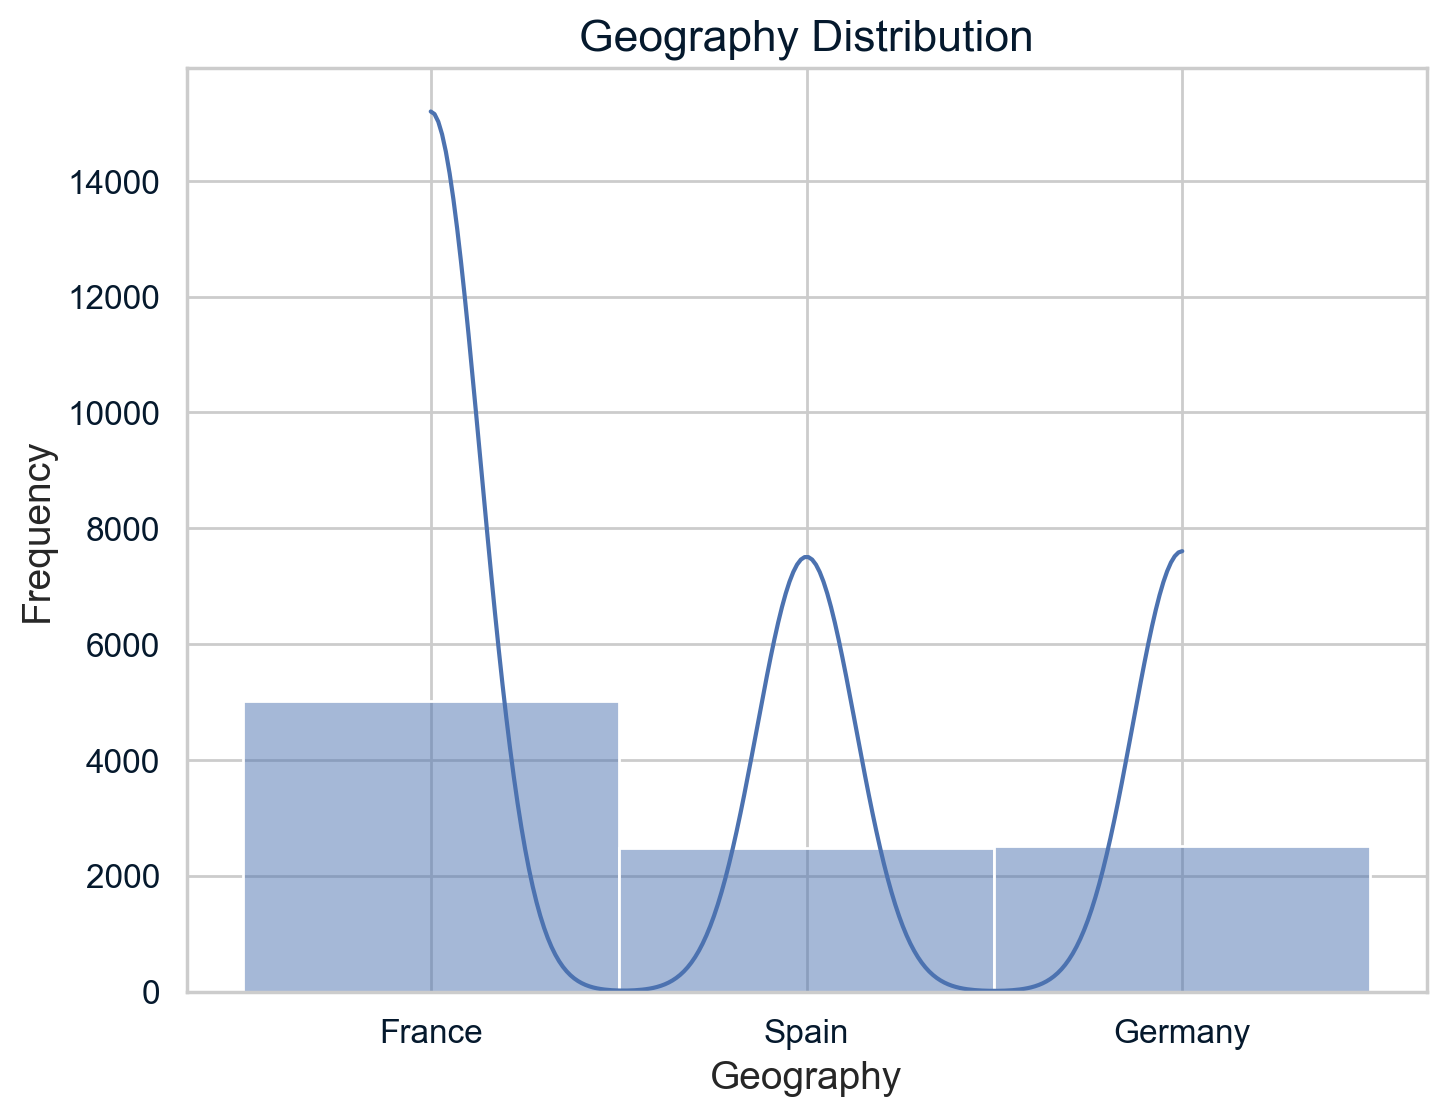

In [12]:
viz_distribution(customers, 'Geography', bin_count=15, discrete=True)

**Insight(s)**: Based on the graph, the bank's customer base is concentrated in France, with a more diverse distribution in Spain and Germany. The bimodal distribution in Germany suggests the presence of two distinct customer segments.

#### Credit Score

Credit scores are a critical factor in assessing credit risk. Visualizing the distribution helps in understanding the overall creditworthiness of the customer base.

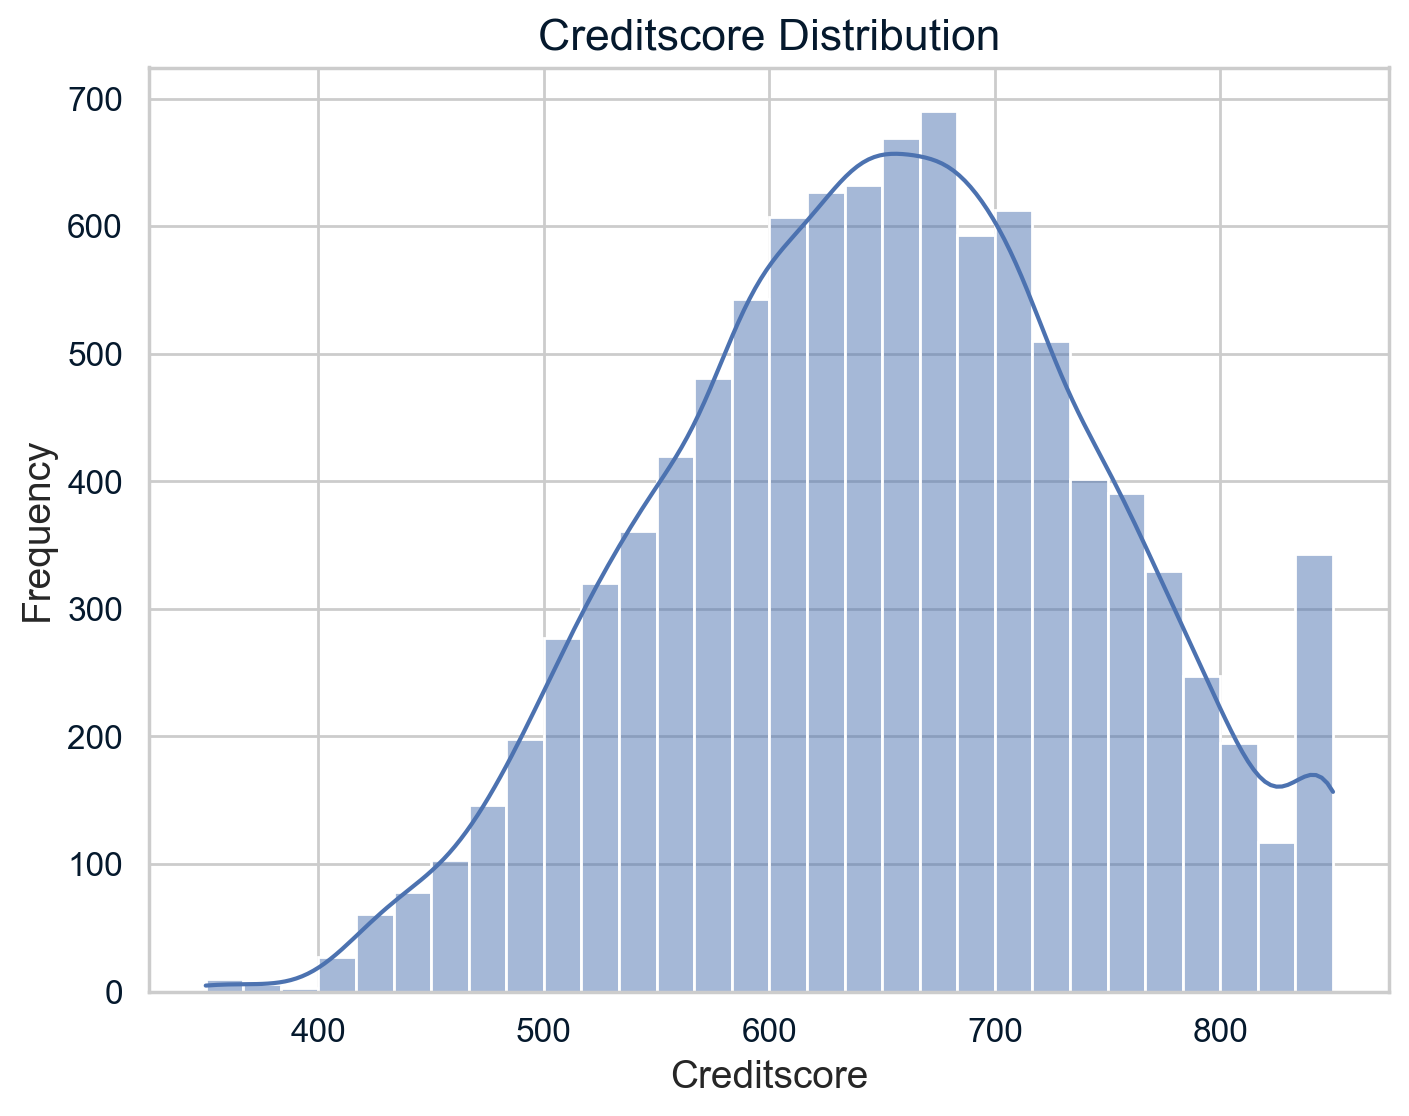

In [13]:
viz_distribution(customers, 'CreditScore', bin_count=30)

**Insight(s)**: Based on the analysis, the credit scores are exhibit a typical normal distribution, with a majority of individuals having credit scores around the median, the slight right skewed indicates the presence of a few individuals with exceptionally high credit scores.

#### Age

Age is a fundamental demographic variable that influences customer behavior and preferences. Visualizing the age distribution helps in understanding the bank's customer demographics.

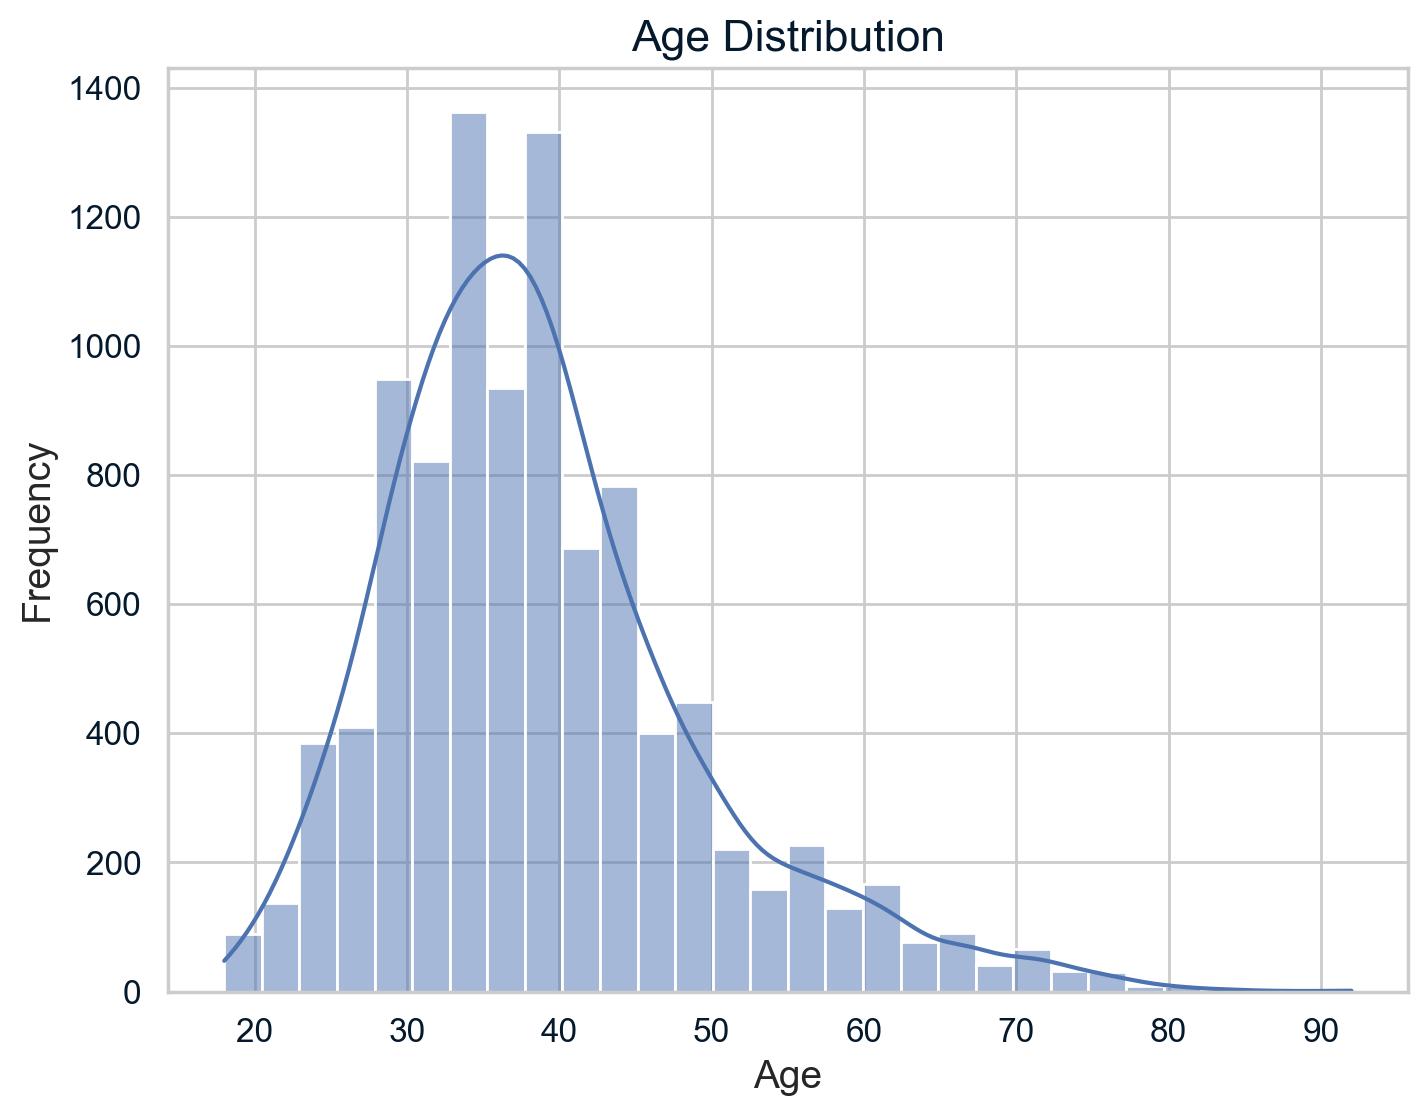

In [14]:
viz_distribution(customers, 'Age', bin_count=30)

**Insight(s)**: Based on this analysis, the age distribution in the dataset is skewed towards younger individuals, with a concentration around the age of 35-40. The wide spread of the distribution suggests a diverse age range among the individuals.

### Relationships


#### Balance vs Has Credit Card

Visualizing the relationship between balance and whether a customer has a credit card can provide insights into the financial behavior of the bank's customers. By analyzing this relationship, the bank can make data-driven decisions to enhance customer satisfaction and optimize their financial products.

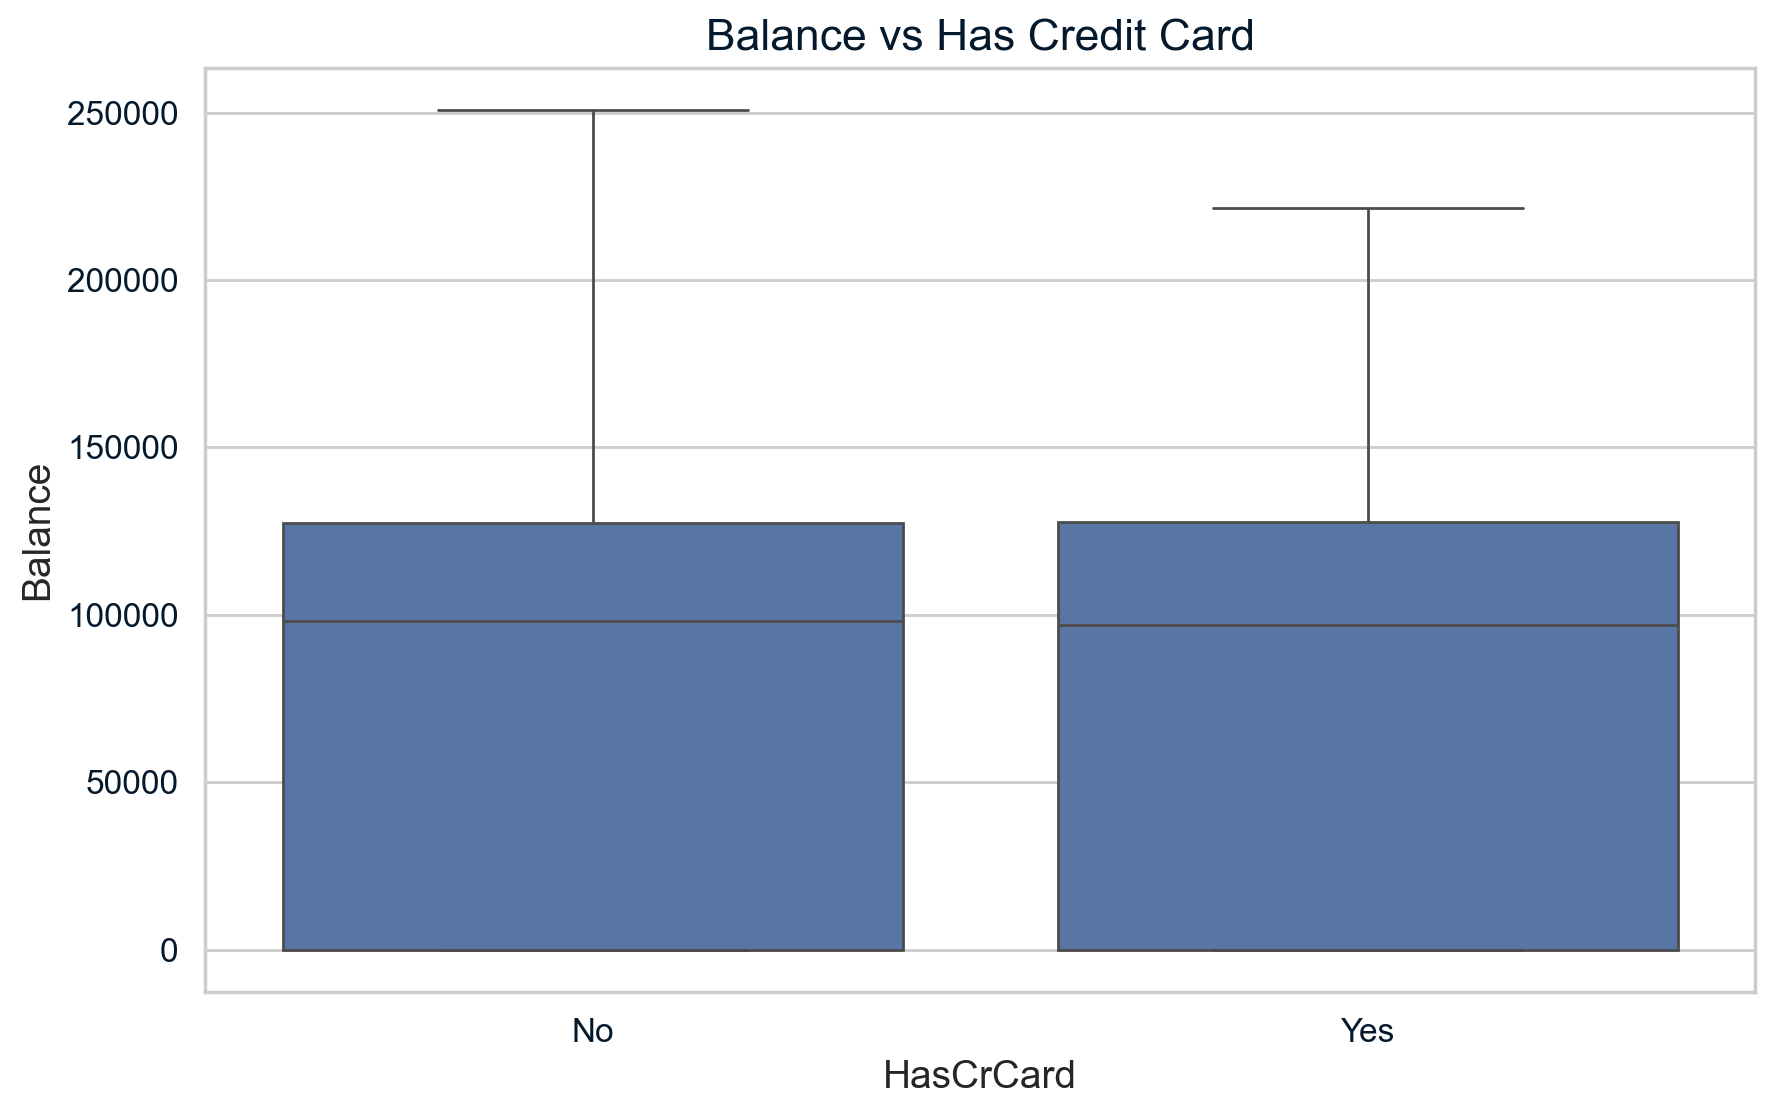

In [15]:
viz_categorical_vs_continuous_box_plot(
    dataset=customers, 
    categorical_feature='HasCrCard', 
    continuous_feature='Balance', 
    plot_title='Balance vs Has Credit Card', 
    x_tick_labels=['No', 'Yes'])

**Insight(s)**: The analysis of the relationship between balance and whether a customer has a credit card reveals that customers with a credit card tend to have higher balances on average compared to those without a credit card. This suggests that having a credit card might be associated with higher financial activity or liquidity. The bank can leverage this insight to tailor financial products and services to customers based on their credit card ownership status.

#### Number of Products vs Tenure

Visualizing this relationship can provide valuable insights into how tenure influences the number of products a customer holds, helping the bank to tailor its marketing and customer service strategies effectively.

Analyzing the relationship between the number of products and tenure is crucial for understanding customer loyalty and product adoption over time. Tenure represents the length of time a customer has been with the bank, and the number of products indicates the variety of services a customer uses. 

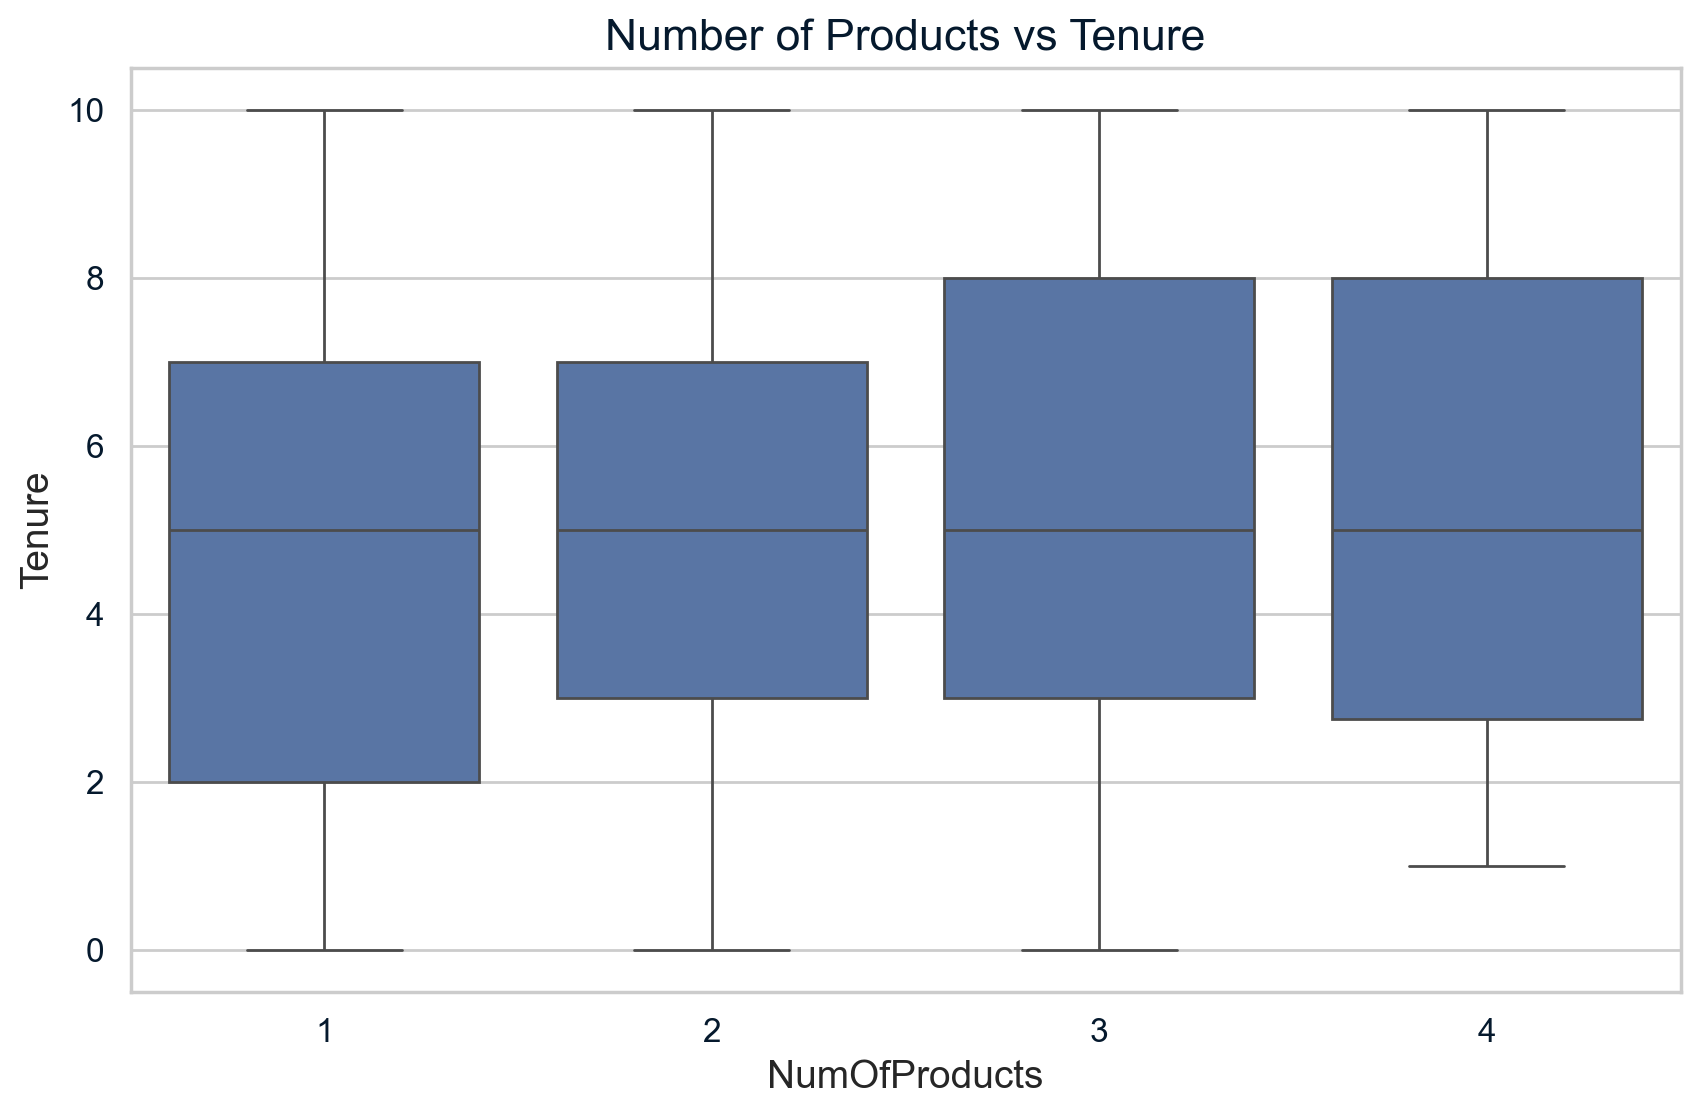

In [16]:
viz_categorical_vs_continuous_box_plot(
    dataset=customers,
    categorical_feature='NumOfProducts',
    continuous_feature='Tenure',
    plot_title='Number of Products vs Tenure',
    x_tick_labels=[str(i) for i in sorted(customers['NumOfProducts'].unique())])

**Insight(s)**: The analysis of the relationship between the number of products and tenure reveals that customers with longer tenure tend to hold more products on average compared to those with shorter tenure. This suggests that customer loyalty and the length of the relationship with the bank are positively correlated with the adoption of multiple financial products. The bank can leverage this insight to design loyalty programs and targeted marketing campaigns to encourage long-term customers to adopt more products, thereby increasing customer retention and revenue.

#### Geography vs Tenure

Visualizing the relationship between geography and tenure can provide valuable insights into regional customer behavior and loyalty patterns. Understanding how tenure varies across different geographic locations can help the bank identify regions with higher customer retention and those that may require targeted retention strategies. This information can be used to tailor regional marketing efforts, improve customer service, and develop location-specific financial products to enhance customer satisfaction and loyalty.

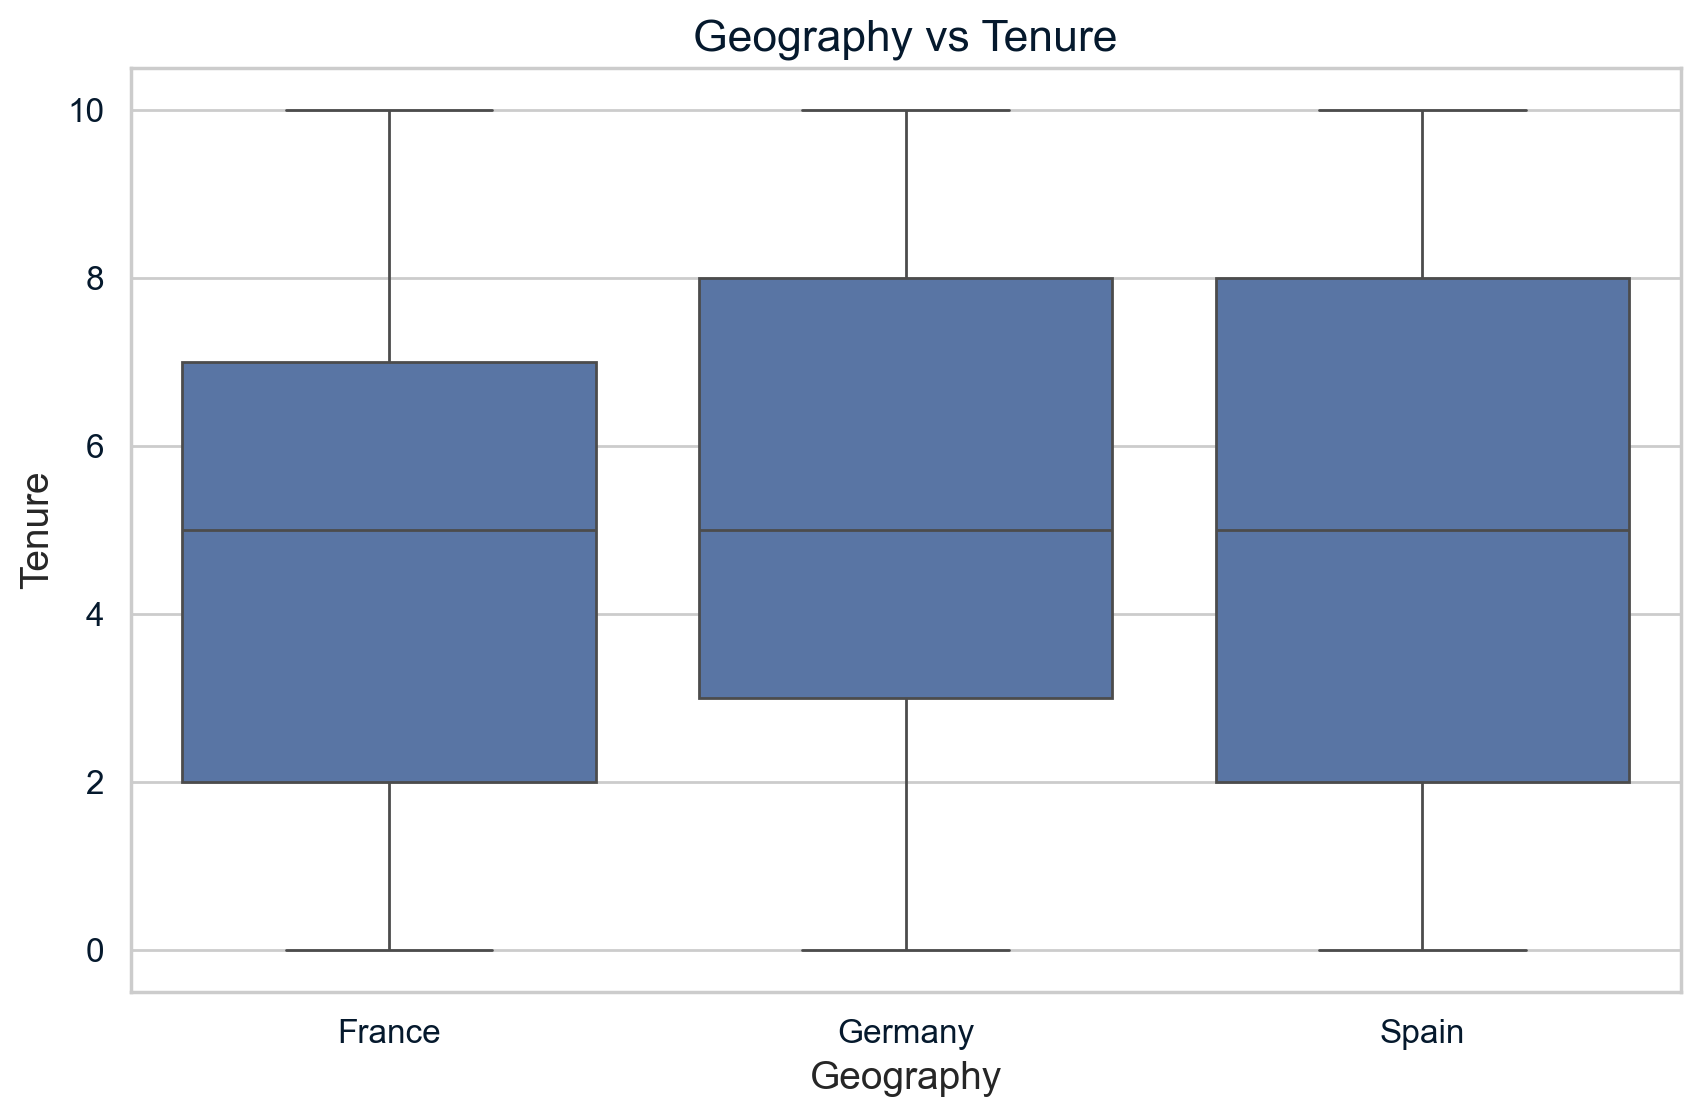

In [17]:
viz_categorical_vs_continuous_box_plot(
    dataset=customers,
    categorical_feature='Geography',
    continuous_feature='Tenure',
    plot_title='Geography vs Tenure',
    x_tick_labels=[str(i) for i in sorted(customers['Geography'].unique())])

**Insight(s)**: The box plot for France shows that French customers tend to have more consistent lengths of time with the bank compared to customers in Germany and Spain. This means that the time French customers stay with the bank doesn't vary as much. On the other hand, customers in Germany and Spain have similar patterns, with a wider range of how long they stay with the bank. Overall, while there are some small differences in how long customers stay in each country, the average time and the overall spread are quite similar.

## V. Data Preprocessing

### Extracting Features for ANN

To build an Artificial Neural Network (ANN), we need to preprocess our data and extract the relevant features. The features we have selected (`X`) are the independent variables that will be used to predict the target variable (`y`). 

#### Why Extract These Features?

1. **CreditScore**: Indicates the creditworthiness of a customer, which can influence their likelihood of exiting the bank.
2. **Geography**: The location of the customer, which can affect customer behavior and preferences.
3. **Gender**: Gender can sometimes play a role in financial decisions and behavior.
4. **Age**: Age is a crucial factor as it can influence financial stability and product needs.
5. **Tenure**: The length of time a customer has been with the bank, which can indicate loyalty.
6. **Balance**: The account balance, which can reflect the financial health of the customer.
7. **NumOfProducts**: The number of products a customer has with the bank, indicating their engagement level.
8. **HasCrCard**: Whether the customer has a credit card, which can affect their financial behavior.
9. **IsActiveMember**: Whether the customer is an active member, indicating their engagement with the bank.
10. **EstimatedSalary**: The estimated salary of the customer, which can influence their financial decisions.

The target variable (`y`) is `Exited`, which indicates whether the customer has exited the bank. By training the ANN with these features, we aim to predict the likelihood of a customer exiting the bank based on their profile and behavior.

- Extracting and preview feature names for `X` and target name for `y`

In [18]:
feature_names_X = customers.columns[3:-1].tolist()
target_name_y = customers.columns[-1]

print(f'Feature names (X):\n{feature_names_X}\n\nTarget name (Y):\n{target_name_y}')

Feature names (X):
['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Target name (Y):
Exited


In [19]:
X = customers.iloc[:, 3:-1].values
y = customers.iloc[:, -1].values


### Encoding Categorical Data

In machine learning, most algorithms require numerical input. Categorical data, which includes variables like `Gender` and `Geography`, need to be converted into a numerical format to be used effectively in these algorithms. This process is known as encoding.

#### Label Encoding for Gender
Label encoding is used for categorical variables that have an intrinsic order or when the categorical variable is binary. In our case, `Gender` is a binary variable with two categories: `Male` and `Female`. Label encoding will convert these categories into numerical values, typically `0` and `1`. This is straightforward and efficient for binary variables.

Example:
- `Male` -> 0
- `Female` -> 1

#### One Hot Encoding for Geography
One hot encoding is used for categorical variables that do not have an intrinsic order and have more than two categories. `Geography` is a categorical variable with multiple categories (e.g., `France`, `Germany`, `Spain`). One hot encoding will create a new binary column for each category, indicating the presence or absence of that category in the data.

Example:
- `France` -> [1, 0, 0]
- `Germany` -> [0, 1, 0]
- `Spain` -> [0, 0, 1]

This approach prevents the model from assuming any ordinal relationship between the categories, which is crucial for maintaining the integrity of the data.

In [20]:
# Label Encoding the 'Gender' column
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

# One Hot Encoding the 'Geography' column
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [1])], remainder='passthrough')
X = ct.fit_transform(X)

- Preview both `X` and `y`.

In [21]:
print(f'X values:\n{X}\n\nY values:\n{y}')

X values:
[[1.0 0.0 0.0 ... 1 1 101348.88]
 [0.0 0.0 1.0 ... 0 1 112542.58]
 [1.0 0.0 0.0 ... 1 0 113931.57]
 ...
 [1.0 0.0 0.0 ... 0 1 42085.58]
 [0.0 1.0 0.0 ... 1 0 92888.52]
 [1.0 0.0 0.0 ... 1 0 38190.78]]

Y values:
[1 0 1 ... 1 1 0]


### Train-Test, Split

When building an Artificial Neural Network (ANN), train-test splitting is essential for building robust and generalizable model, ensuring that the model performs well not just on the training data but also on new, unseen data.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- `train_test_split`: This is a function from the `sklearn.model_selection` module that splits arrays or matrices into random train and test subsets.

- `X`: This is the feature matrix containing the input features for the model.

- `y`: This is the target vector containing the labels or the output variable that the model is trying to predict.

- `test_size=0.2`: This parameter specifies the proportion of the dataset to include in the test split. In this case, 20% of the data will be used for testing, and the remaining 80% will be used for training.

- `random_state=42`: This parameter controls the shuffling applied to the data before the split. Providing a `random_state` ensures reproducibility of the results. Using the same `random_state` value will always produce the same split.

- `X_train`: This is the portion of `X` used for training the model.

- `X_test`: This is the portion of `X` used for testing the model.

- `y_train`: This is the portion of `y` used for training the model.

- `y_test`: This is the portion of `y` used for testing the model.

In summary, this line of code splits the dataset into training and testing sets, ensuring that 80% of the data is used for training and 20% is used for testing, with a fixed random state for reproducibility.

### Scale The Features


Scaling the features is an essential step in preprocessing the data before training a machine learning model. The primary reason for scaling is to ensure that all features contribute equally to the model's performance. 

- **Why Scale the Features?**
  - **Uniformity**: Features in the dataset may have different units and scales. For example, age might range from 18 to 100, while balance might range from 0 to 250,000. Scaling ensures that each feature contributes equally to the model.
  - **Improved Convergence**: Many machine learning algorithms, especially gradient-based methods like neural networks, converge faster when the features are scaled. This is because the optimization process is more efficient when the data is on a similar scale.
  - **Reduced Bias**: Without scaling, features with larger ranges can dominate the learning process, leading to biased models. Scaling helps in mitigating this issue.

- **How to Scale the Features using `StandardScaler`?**
  - `StandardScaler` standardizes features by removing the mean and scaling to unit variance. This means each feature will have a mean of 0 and a standard deviation of 1.


In [23]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## VI. Building ANN

### Build

To build an Artificial Neural Network (ANN) using Keras, we need to understand some key components:

1. **Sequential**: This is a linear stack of layers. It allows you to build a model layer-by-layer. You can create a Sequential model by passing a list of layer instances to the constructor.

2. **Dense**: This layer is a regular deeply connected neural network layer. It is the most common layer used in ANNs. Each neuron in a Dense layer receives input from all neurons of the previous layer, making it a fully connected layer.

3. **Input**: This is used to instantiate a Keras tensor. It is the entry point of the model where you define the shape and dtype of the input data.

4. **Dropout**: This layer is used to prevent overfitting. It randomly sets a fraction of input units to 0 at each update during training time, which helps in regularizing the model.

In [24]:
shape = (X_train.shape[1], )
model = build_ann_model(shape)

### Compile

To compile the model, we need to specify the optimizer, loss function, and metrics. This step is crucial because it configures the model for training. Here’s why we use specific components like optimizers and callbacks:

1. **Optimizers (e.g., Adam)**:
   - **Purpose**: Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses.
   - **Adam**: The Adam optimizer is popular because it combines the advantages of two other extensions of stochastic gradient descent. Specifically, it combines the benefits of Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). Adam is computationally efficient, has little memory requirement, is invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data and/or parameters.

2. **Callbacks (e.g., EarlyStopping)**:
   - **Purpose**: Callbacks are a way to perform actions at various stages of training (e.g., at the end of an epoch). They can be used to monitor the training process and take actions such as saving the model or stopping training.
   - **EarlyStopping**: This callback is used to stop training when a monitored metric has stopped improving. It helps in preventing overfitting by terminating the training process once the performance on a validation dataset starts to degrade. This ensures that the model does not learn noise from the training data and generalizes well to unseen data.

In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

- Preview the summary of the model

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train

Training a model is a crucial step in machine learning where the model learns from the data. During training, the model iteratively adjusts its parameters to minimize the loss function, which measures the difference between the predicted and actual values. This process helps the model to generalize well to new, unseen data.

In [27]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=(es), verbose=1)

Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7454 - loss: 0.5544 - val_accuracy: 0.8206 - val_loss: 0.4296
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.4725 - val_accuracy: 0.8275 - val_loss: 0.4143
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8042 - loss: 0.4612 - val_accuracy: 0.8350 - val_loss: 0.4070
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8104 - loss: 0.4409 - val_accuracy: 0.8394 - val_loss: 0.4019
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8088 - loss: 0.4393 - val_accuracy: 0.8413 - val_loss: 0.3923
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8325 - loss: 0.4114 - val_accuracy: 0.8456 - val_loss: 0.3867
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8308 - loss: 0.4131 - val_accuracy: 0.8487 - val_loss: 0.3772
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8361 - loss: 0.4068 - val_accu

- `X_train` and `y_train`: These are the training data and labels, respectively. `X_train` contains the input features, while `y_train` contains the target labels.

- `epochs=200`: This specifies the number of times the entire training dataset will be passed through the model. In this case, the model will be trained for 200 epochs.

- `batch_size=32`: This defines the number of samples that will be propagated through the model at once. The model updates its parameters after each batch. Here, the batch size is set to 32.

- `validation_split=0.2`: This indicates that 20% of the training data will be set aside for validation. The model will not train on this data but will use it to evaluate its performance after each epoch.

- `callbacks=(es)`: This specifies the callback functions to be used during training. In this case, `es` is an instance of `EarlyStopping`, which monitors the validation loss and stops training if it doesn't improve for a specified number of epochs (patience). It also restores the best weights once training is stopped.

- `verbose=1`: This controls the verbosity of the training process. When set to 1, it will display a progress bar for each epoch, showing the training and validation loss and accuracy.

The result of this training process is stored in the `history` variable, which contains information about the training and validation loss and accuracy for each epoch. This can be useful for analyzing the model's performance over time.

#### Plot Training History

Plotting the training history is essential for several reasons:

1. **Visualize Model Performance**: It allows you to visualize how the model's performance changes over epochs. By plotting the training and validation loss and accuracy, you can see if the model is learning effectively or if it is overfitting or underfitting.

2. **Identify Overfitting/Underfitting**: By comparing the training and validation curves, you can identify if the model is overfitting (training accuracy is high, but validation accuracy is low) or underfitting (both training and validation accuracy are low).

3. **Monitor Convergence**: It helps in monitoring whether the model is converging towards a minimum loss or if it is stuck at a plateau. This can inform decisions about whether to continue training or to stop early.

4. **Adjust Hyperparameters**: Insights gained from the plots can guide adjustments to hyperparameters such as learning rate, batch size, and the number of epochs to improve model performance.

5. **Debugging**: If the model is not performing as expected, the plots can provide clues about what might be going wrong, such as learning rate issues or data preprocessing problems.

Overall, plotting the training history is a valuable tool for diagnosing and improving the model's performance.

##### Accuracy

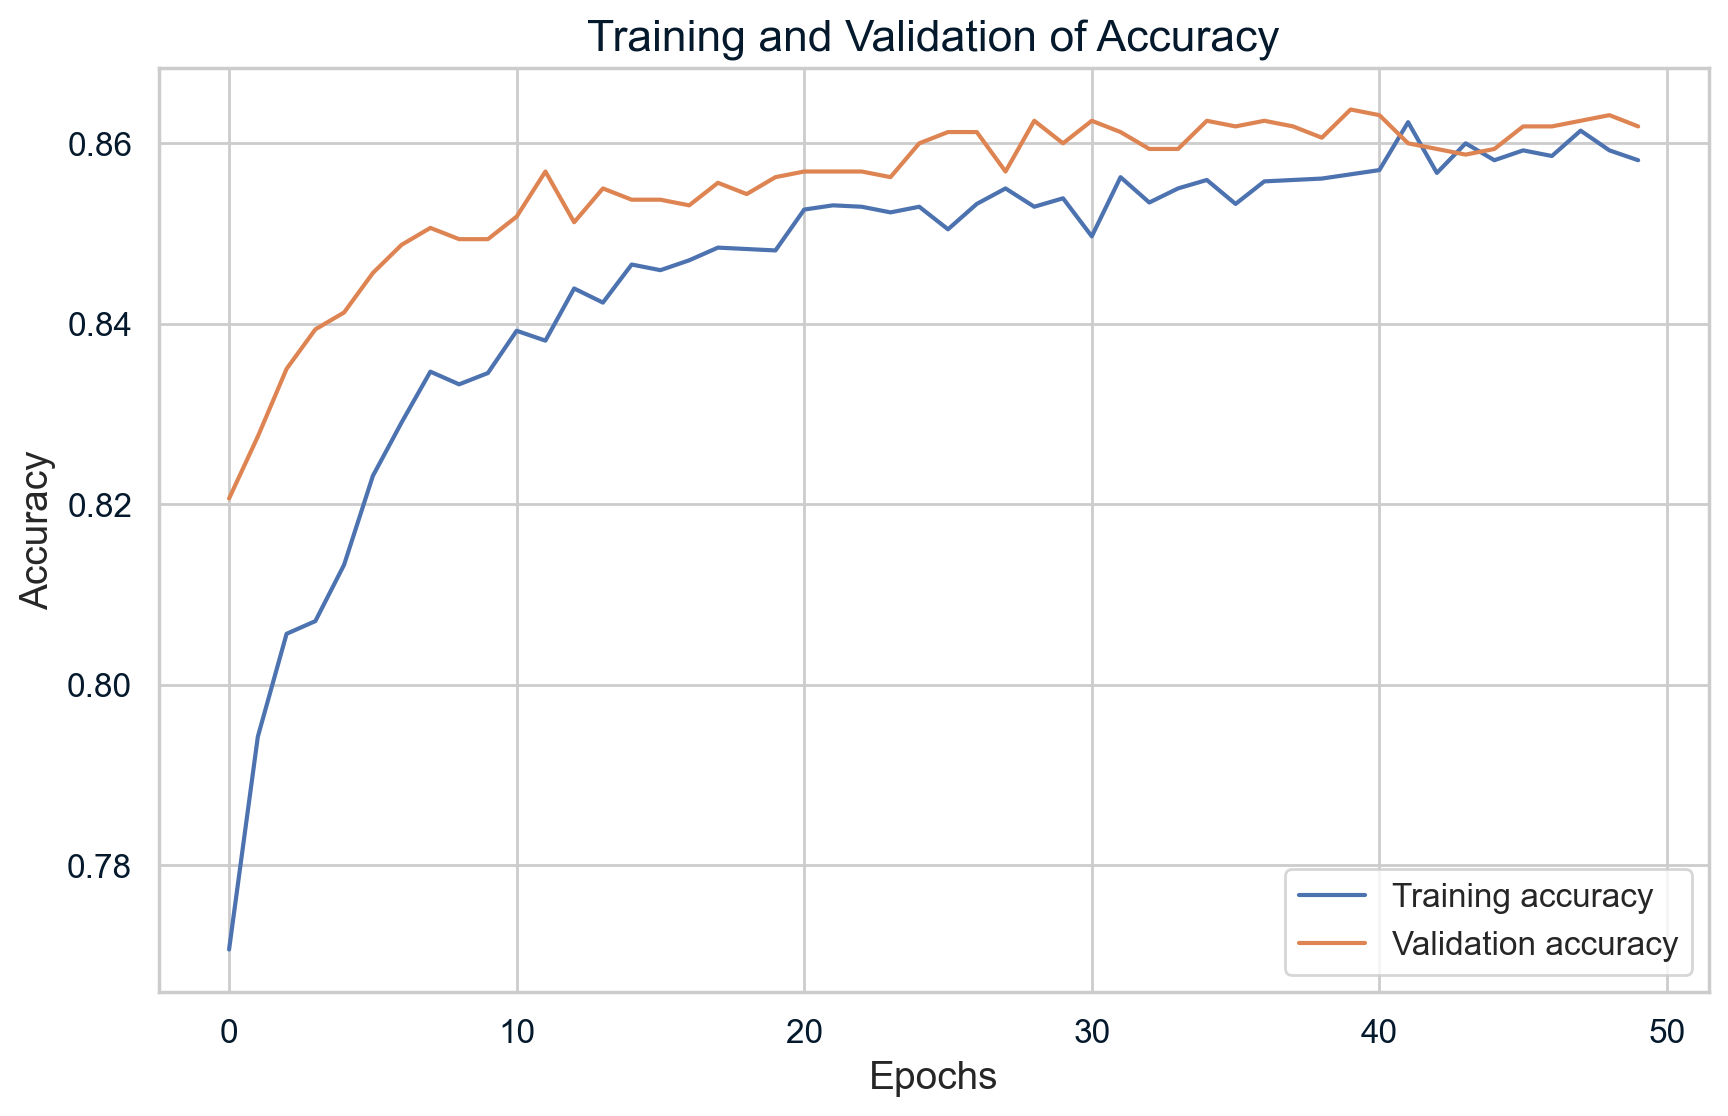

In [28]:
viz_history(history, 'accuracy')

**Insight(s)**: The model is demonstrating promising performance. The steady increase in both training and validation accuracy suggests that the model is effectively learning the underlying patterns in the data. The narrowing gap between the two curves indicates that the model is generalizing well to unseen data, which is a crucial aspect of a successful model.

##### Loss

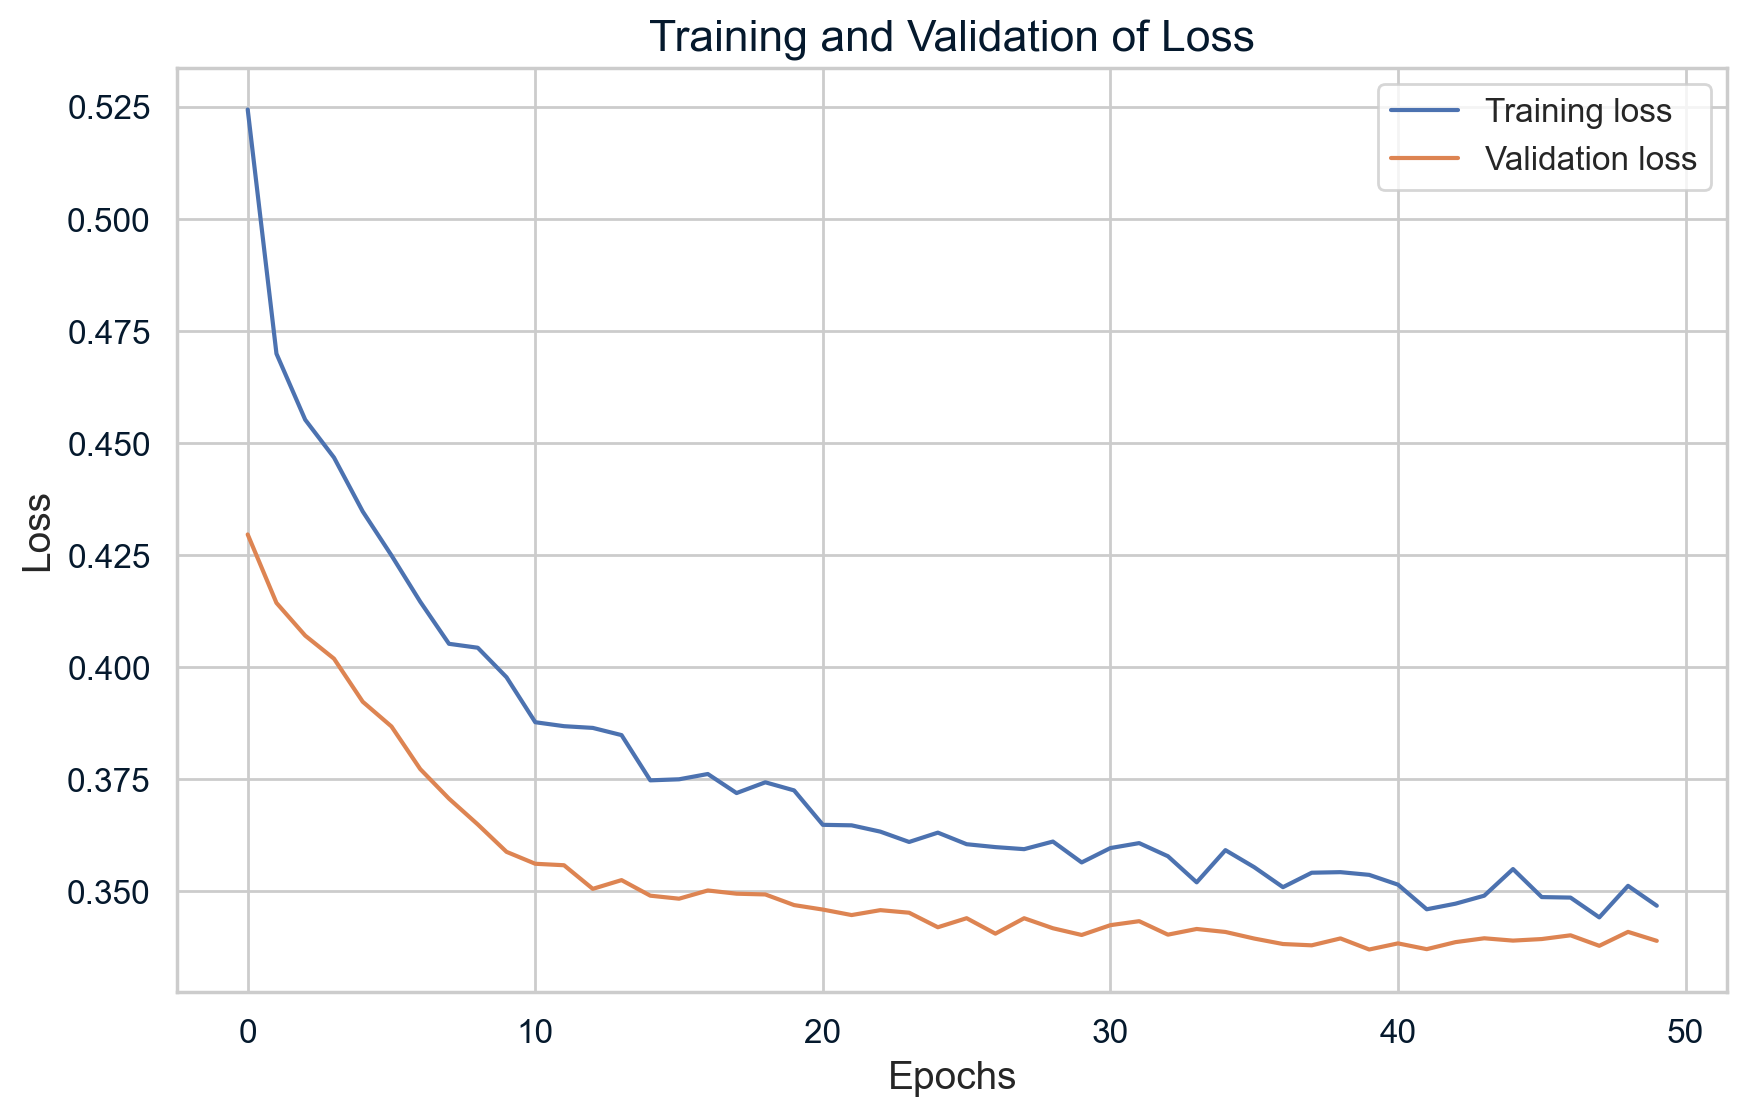

In [29]:
viz_history(history, 'loss')

**Insight(s)**: The model is showing initial promise with decreasing loss, but the signs of overfitting are concerning. Overfitting occurs when a model becomes too complex and starts memorizing the training data instead of learning underlying patterns. This can lead to poor performance on new, unseen data.

### Evaluate

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)

# Display the evaluation results in a more structured format
print(f"\nTest Results:\n- Loss: {loss:.4f}\n- Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.8626 - loss: 0.3335

Test Results:
- Loss: 0.3354
- Accuracy: 0.8625


**Insight(s)**: The evaluation results indicate that the model has achieved a test accuracy of 85% and a test loss of 0.33. These results are consistent with the training and validation performance, suggesting that the model is generalizing well to unseen data. The model demonstrates robust performance and is likely to perform well in real-world scenarios.